In [1]:
# %load REINFORCE.py
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

import matplotlib.pyplot as plt
import numpy as np
import time 
from IPython.display import clear_output

In [2]:
#Hyperparameters
learning_rate = 0.0002
gamma         = 0.98

# I. Define Policy
## 1.1 init

* Softmax in action preference
* $h(a,s,\theta)$ -- ANN
  * 1 hidden layer, of 128 neurons
  * Activation Func, relu
  * Output layer, Softmax (softmax in action preference!)

# 1.2 train_net, update rules for $\theta$
$$ G \leftarrow \sum^T_{k=t+1} \gamma ^{k-t-1}R_k$$
$$ \theta \leftarrow \theta + \alpha \gamma ^t G \nabla \ln \pi (A_t|S_t, \theta) $$

In [3]:
class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        self.data = []     # data of 1 entire episode

        # I. ================================
        # 1.1 Initial Policy network (1)
        self.fc1 = nn.Linear(4, 128)
        self.fc2 = nn.Linear(128, 2)
        # ===================================

        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)
        
    def forward(self, x):

        # I. ================================
        # 1.1 Initial Policy network (2)
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x), dim=0)
        # ===================================

        return x
      
    def put_data(self, item):     # adding data of 1 step
        self.data.append(item)
        
    def train_net(self):
        self.optimizer.zero_grad()
        G = 0

        # III. ==============================
        # 3. Loop for each step of the episode, update theta
        for r, prob in self.data[::-1]:
            G = r + gamma * G
            loss = -torch.log(prob) * G
            loss.backward()
        # ===================================

        self.optimizer.step()
        self.data = []

In [33]:
env = gym.make('CartPole-v1')
s = env.reset()[0]
pi = Policy()
pi(torch.Tensor(s))

tensor([0.4690, 0.5310], grad_fn=<SoftmaxBackward0>)

# III. Sample, and train

In [4]:
env = gym.make('CartPole-v1')
pi = Policy()
score = 0.0
print_interval = 20
li_score = []

In [ ]:
for n_epi in range(2000):
    s, _ = env.reset()
    done = False
    
    while not done: # CartPole-v1 forced to terminates at 500 step.
        # II. ================================
        # 2.1 Sample action, according to pi
        prob = pi(torch.from_numpy(s).float())
        m = Categorical(prob)
        a = m.sample()

        # 2.2 observe next step, and Record data of 1 step with "pi.put_data", putting (r, prob[a])
        s_prime, r, done, _, _ = env.step(a.item())

        # 2.2.1 Record data of 1 step with "pi.put_data", putting (r, prob[a])
        pi.put_data((r,prob[a]))

        # 2.3 Next step
        s = s_prime
        score += r
        # ===================================
        
    # 3. Train net
    pi.train_net()
    
    if n_epi%print_interval==0 and n_epi!=0:
        print("# of episode :{}, avg score : {}".format(n_epi, score/print_interval))
        score = 0.0
    li_score.append(score)
env.close()

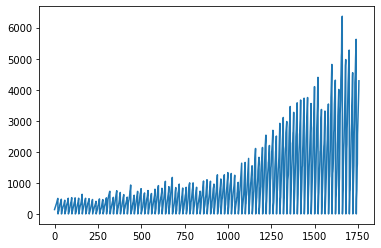

In [184]:
plt.plot(li_score)

# IV. Observe carpole, with current pi
1 episode

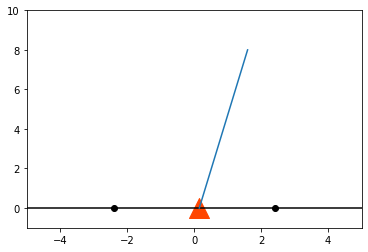

Episode finished after 21 timesteps


In [28]:
s, _ = env.reset()
done = False
li_si = []
t = 0

while not done: # CartPole-v1 forced to terminates at 500 step.
    # 2.0 show
    plt.plot([-5, 5], [0,0], c='black')
    plt.scatter([-2.4, 2.4], [0,0], c='black')
    plt.scatter(s[0], 0, marker='^', c='#FF4500', s = 400)
    plt.plot([s[0], s[0] + 8*np.tan(s[1]*10/180*np.pi)], [0,8])
    plt.xlim(-5,5)
    plt.ylim(-1,10)
    clear_output(True)
    plt.show()
    plt.pause(0.005)

    li_si.append(s[1])

    # 2.1 Sample action, according to pi
    prob = pi(torch.from_numpy(s).float())
    m = Categorical(prob)
    a = m.sample()

    # 2.2 observe next step, and Record data of 1 step with "pi.put_data", putting (r, prob)
    s_prime, r, done, _, _ = env.step(a.item())

    # 2.3 Next step
    s = s_prime
    score += r

    t += 1
    
    if done:
        print("Episode finished after {} timesteps".format(t+1))